<a href="https://colab.research.google.com/github/havaledar/6200/blob/main/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1 by AA

In [1]:
###############################
#### DATA*6200 F22
#### Assignment 1
###############################

## reading in data
library(tidyverse)
foot <- read.csv("https://raw.githubusercontent.com/havaledar/6200/main/afferentData.csv", sep=",", skip=1, header=F)
colnames(foot) <- c("session","afferent", "subject", "sex", "age", "afferentClass","genloc","specloc",
                    "RFsize", "RFhardness","frequency","amplitude", "AvgInst", "peak3","impCycle")
foot <- data.frame(foot)

## identify missing values
# > rownames(foot)[(is.na(foot$impCycle))]
# [1] "474"
# foot[474,]

## remove them for this analysis
foot <- foot[-474,]

## pull out unique afferents and
## label unique afferents in database
Unique.aff <- distinct(foot, session, afferent, subject, afferentClass)
Unique.aff <- Unique.aff[order(Unique.aff$afferent, Unique.aff$subject, Unique.aff$afferentClass),]

## need (subject and afferent) to uniquely define an afferent
## create newID so only need one variable to identify afferent
foot$newID <- rep(0,nrow(foot))
for(i in 1:nrow(Unique.aff)){ 
  affid1 <- Unique.aff$subject[i]   # subsetting single afferent
  affid2 <- Unique.aff$afferent[i]
  foot$newID[foot$subject==affid1 & foot$afferent==affid2] <- i
}
## move new afferentID to just after original afferent ID
foot <- foot %>% relocate(newID, .after = afferent)

#################################################################
## Q1 staring descriptives...
#################################################################
## identify unique afferents by session, subject, afferent, class
##order columns with characters together and continuous together
uniqueAfferents <- foot[!duplicated(foot$newID), c(1:4,7,5,8:9,6,10:16)]

# cross-tabulate by subject and afferent class
afferentSummary <- table(uniqueAfferents$subject, uniqueAfferents$afferentClass)

# add row sums to count total number afferents per subject
afferentSummary <- cbind(afferentSummary, rowSums(afferentSummary))

# count number observations per subject, append to afferentSummary
numObs <- as.data.frame(foot %>% group_by(subject) %>% tally())
afferentSummary <- cbind(afferentSummary, numObs$n)
colnames(afferentSummary)[5:6] <- c("nafferents", "numObs")

# append column sums to tally number afferents by class, and total number obs
afferentSummary <- rbind(afferentSummary, colSums(afferentSummary))
rownames(afferentSummary)[length(rownames(afferentSummary))] <- "Totals"

nsessions <- length(unique(uniqueAfferents$session))
nsubjects <- apply(afferentSummary[-17,1:4],2, function(x){return(sum(x>0))})

#######################################
## Q2 table of demographic information#
#######################################

## using tables overall and then by afferent class, 
## use cbind to collate them into one table
sexSummary <- apply(table(uniqueAfferents$sex,uniqueAfferents$afferentClass),1,sum)
sexSummary <- cbind(sexSummary, round(addmargins(table(uniqueAfferents$sex,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

genSummary <- apply(table(uniqueAfferents$genloc,uniqueAfferents$afferentClass),1,sum)
genSummary <- cbind(genSummary, round(addmargins(table(uniqueAfferents$genloc,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

specSummary <- apply(table(uniqueAfferents$specloc,uniqueAfferents$afferentClass),1,sum)
specSummary <- cbind(specSummary, round(addmargins(table(uniqueAfferents$specloc,uniqueAfferents$afferentClass),2)/max(uniqueAfferents$newID),2))

## bind the rows of the demographic tables together
## to provide a single unified table
charSummary <- rbind(sexSummary, genSummary)
charSummary <- rbind(charSummary, specSummary)
charSummary <- rbind(charSummary, apply(sexSummary,2,sum))
colnames(charSummary)[1] <- "n"

## descriptives for continuous variables
## count number of missing values
var.list <- c("age", "RFsize", "RFhardness")
sapply(var.list, function(var){sum(is.na(uniqueAfferents[[var]]))})

## overall summaries and summaries by afferent class
## BUT need to filter table to remove NAs
## before calculating summary stats
## Also need to compute overall stats separate
## from afferent class specific stats
## and then bind the table togethe (rowwise)

## Age
all_ageSummary <- uniqueAfferents %>% 
  filter(!is.na(age)) %>% select(age) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(age), stdev=sd(age), min=min(age), max=max(age))
ageSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(age)) %>% select(age) %>%
  summarise(n=n(), mean=mean(age), stdev=sd(age), min=min(age), max=max(age))
ageSummary <- bind_rows(all_ageSummary, ageSummary)

## Receptive Field Size
all_rfsSummary <- uniqueAfferents %>% 
  filter(!is.na(RFsize)) %>% select(RFsize) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(RFsize), stdev=sd(RFsize), min=min(RFsize), max=max(RFsize))
rfsSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(RFsize)) %>% select(RFsize) %>%
  summarise(n=n(), mean=mean(RFsize), stdev=sd(RFsize), min=min(RFsize), max=max(RFsize))
rfsSummary <- bind_rows(all_rfsSummary, rfsSummary)

## Receptive Field Hardness
all_rfhSummary <- uniqueAfferents %>% 
  filter(!is.na(RFhardness)) %>% select(RFhardness) %>%
  summarise(afferentClass="overall", n=n(), mean=mean(RFhardness), stdev=sd(RFhardness), 
            min=min(RFhardness), max=max(RFhardness))
rfhSummary <- uniqueAfferents %>% group_by(afferentClass) %>% 
  filter(!is.na(RFhardness)) %>% select(RFhardness) %>%
  summarise(n=n(), mean=mean(RFhardness), stdev=sd(RFhardness), 
            min=min(RFhardness), max=max(RFhardness))
rfhSummary <- bind_rows(all_rfhSummary, rfhSummary)

## combine all quantitative variable stats together into one table
quantSummary <- bind_rows(ageSummary, rfsSummary, rfhSummary)


#########################################################
## Q3. Compute firing threshold and entrianment threshold
##     which differs for each afferent at each frequency
#########################################################

ft <- foot %>%   # firing threshold
  group_by(newID, frequency) %>%
  filter(impCycle > 0)  %>%
  summarise(firingThreshold = min(amplitude)) %>%
  ungroup()

ent <- foot %>%   # entrainment threshold
  group_by(newID, frequency) %>%
  filter(impCycle > 0.9)  %>%
  summarise(entrainThreshold = min(amplitude))%>%
  ungroup()

## merge it back with full data, first 
## firing threshold then entrainment threshold 
footJoined <- foot %>% left_join(ft, by=c("newID", "frequency")) %>%
                     left_join(ent, by=c("newID", "frequency")) 

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



age     RFsize RFhardness 
         0          1          3

Adding missing grouping variables: `afferentClass`
Adding missing grouping variables: `afferentClass`
Adding missing grouping variables: `afferentClass`
`summarise()` has grouped output by 'newID'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'newID'. You can override using the
`.groups` argument.


#A2 by MH

#Question 1

## a

In [29]:
colnames(footJoined)

[1] "session"          "afferent"         "newID"            "subject"         
 [5] "sex"              "age"              "afferentClass"    "genloc"          
 [9] "specloc"          "RFsize"           "RFhardness"       "frequency"       
[13] "amplitude"        "AvgInst"          "peak3"            "impCycle"        
[17] "firingThreshold"  "entrainThreshold"

In [37]:
impQ1 <- footJoined %>%
  group_by(newID, impCycle, afferentClass) %>%
  summarize()
firQ1 <- footJoined %>%
  group_by(newID, firingThreshold, afferentClass) %>%
  summarize()
entQ1 <- footJoined %>%
  group_by(newID, entrainThreshold, afferentClass) %>%
  summarize()

`summarise()` has grouped output by 'newID', 'impCycle'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'newID', 'firingThreshold'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'newID', 'entrainThreshold'. You can
override using the `.groups` argument.


In [ ]:
#Plotting impulses per cycle, firing threshold, and entrainment thrsehold by afferent class

ggplot(data=subset(impQ1, !is.na(impCycle)), aes(afferentClass, impCycle)) + geom_boxplot() + xlab("Afferent class") + ylab("Impulses per cycle")
ggplot(data=subset(firQ1, !is.na(firingThreshold)), aes(afferentClass, firingThreshold)) + geom_boxplot() + xlab("Afferent class") + ylab("Firing Threshold")
ggplot(data=subset(entQ1, !is.na(entrainThreshold)), aes(afferentClass, entrainThreshold)) + geom_boxplot() + xlab("Afferent class") + ylab("Entrain Threshold")

##b

In [42]:
firQ2 <- footJoined %>%
  group_by(newID, afferentClass, frequency, firingThreshold) %>%
  summarize()
entQ2 <- footJoined %>%
  group_by(newID, afferentClass, frequency, entrainThreshold) %>%
  summarize()

`summarise()` has grouped output by 'newID', 'afferentClass', 'frequency'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'newID', 'afferentClass', 'frequency'. You
can override using the `.groups` argument.


In [ ]:
#todo: plot points with different shaps to compare with the overal trend

firQ2 %>% 
filter(afferentClass=="FAI") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("FAI")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(firingThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

firQ2 %>% 
filter(afferentClass=="FAII") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("FAII")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(firingThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

firQ2 %>% 
filter(afferentClass=="SAI") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("SAI")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(firingThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

firQ2 %>% 
filter(afferentClass=="SAII") %>% 
ggplot(aes(frequency, firingThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("SAII")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(firingThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(firingThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

##c

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 14 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 14 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 12 row(s) containing missing values (geom_path).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 5 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 5 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 5 row(s) 

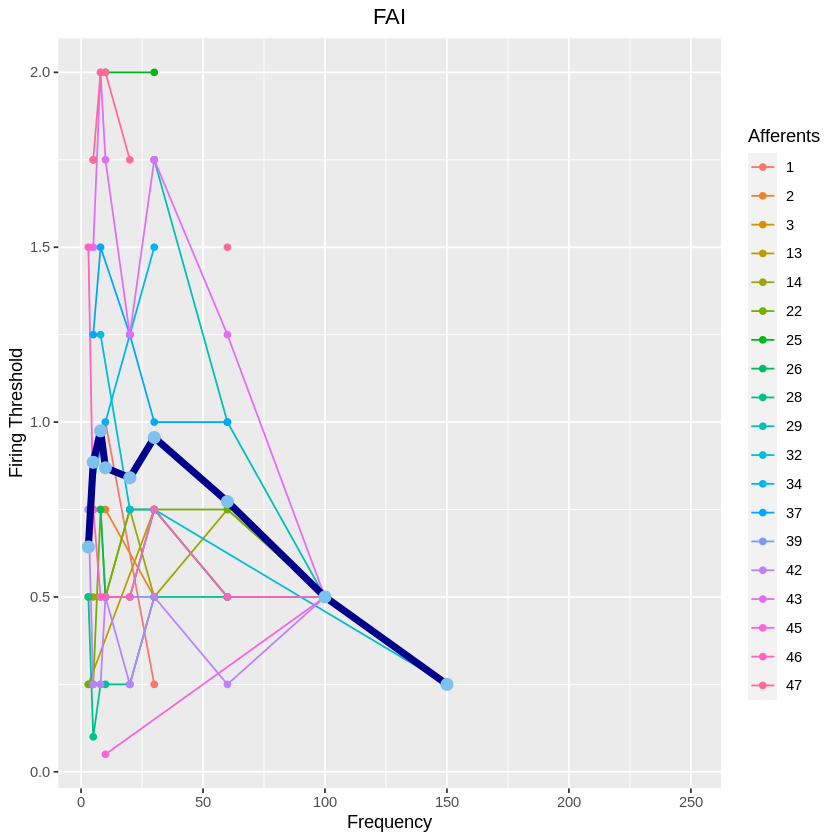

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 17 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 17 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 17 row(s) containing missing values (geom_path).”
Warning message:
“Removed 17 rows containing missing values (geom_point).”


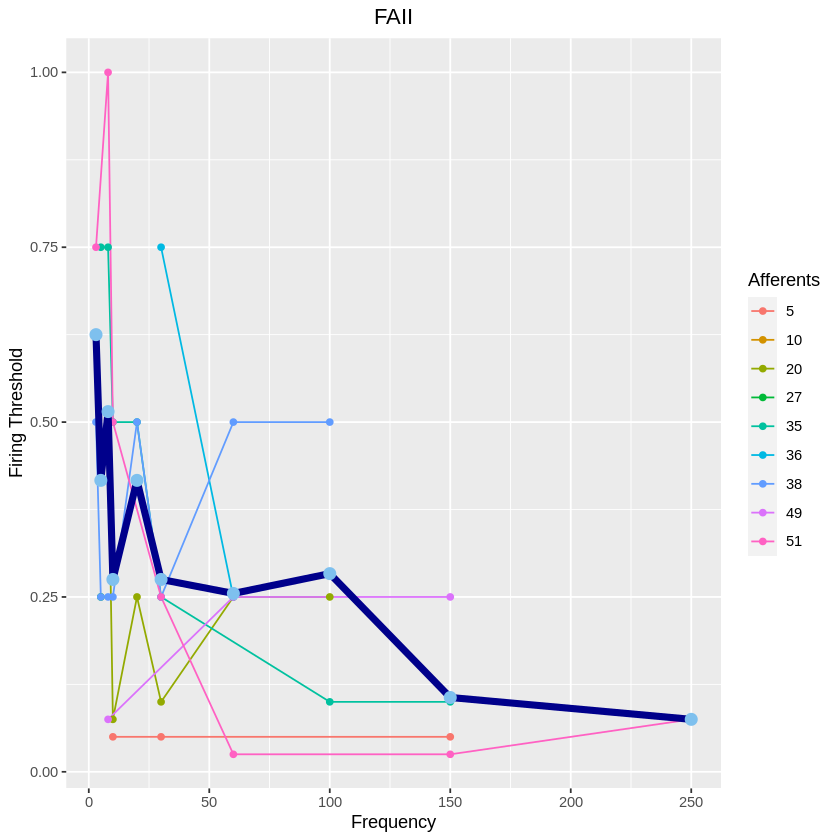

Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Ignoring unknown parameters: entrainThreshold.y”
Warning message:
“Removed 17 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 17 rows containing non-finite values (stat_summary).”
No summary function supplied, defaulting to `mean_se()`

Warning message:
“Removed 17 row(s) containing missing values (geom_path).”
Warning message:
“Removed 17 rows containing missing values (geom_point).”


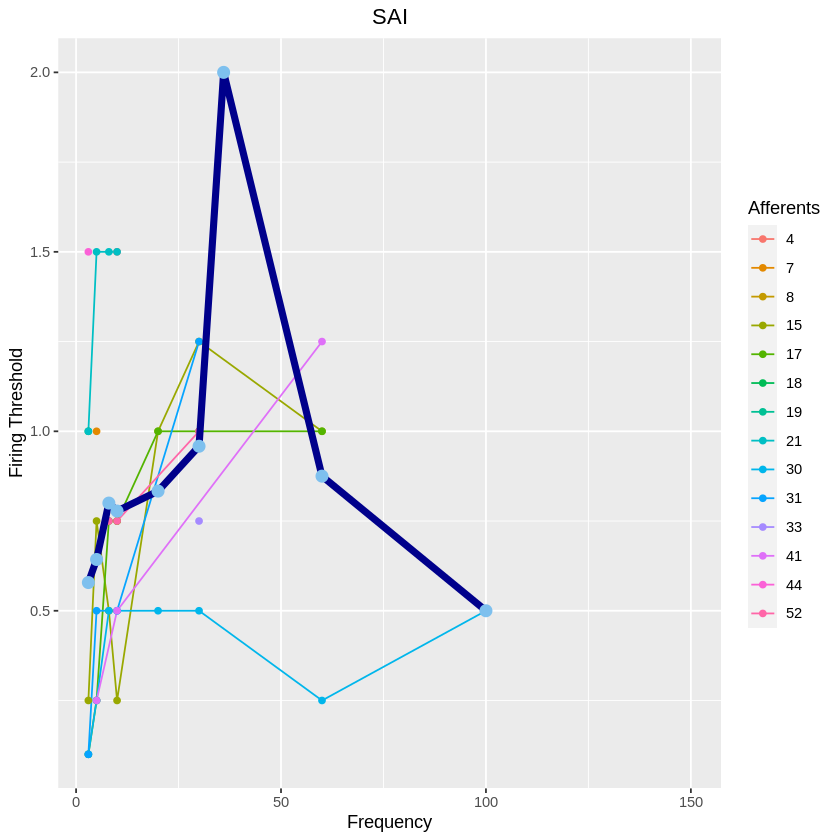

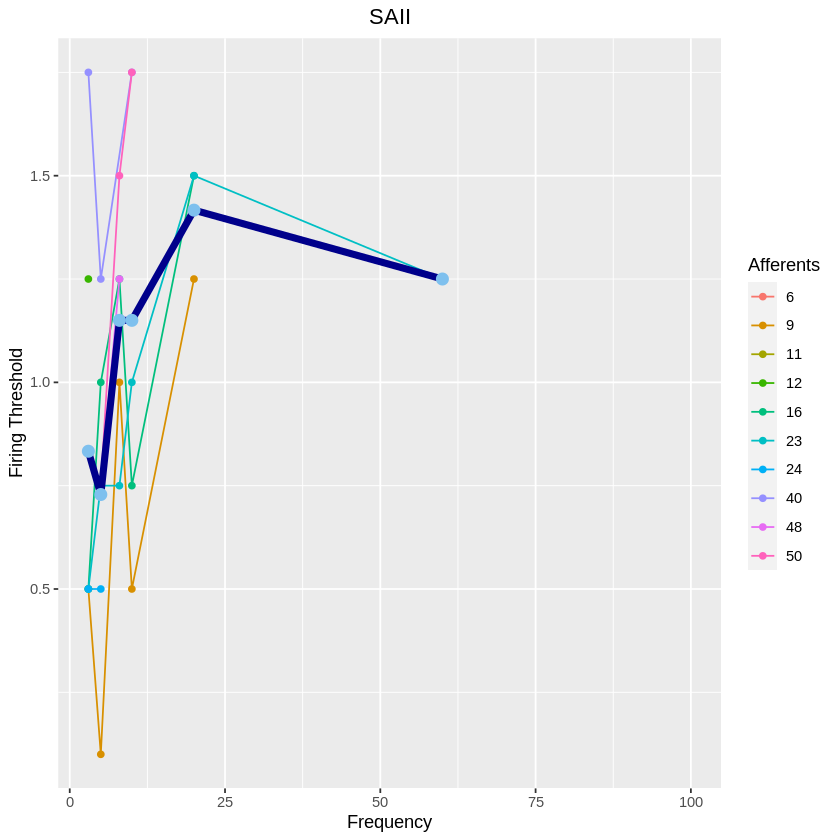

In [68]:
entQ2 %>% 
filter(afferentClass=="FAI") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("FAI")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(entrainThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

entQ2 %>% 
filter(afferentClass=="FAII") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("FAII")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(entrainThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

entQ2 %>% 
filter(afferentClass=="SAI") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("SAI")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(entrainThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

entQ2 %>% 
filter(afferentClass=="SAII") %>% 
ggplot(aes(frequency, entrainThreshold)) + geom_line(aes (color = as.factor(newID))) + geom_point(aes (color = as.factor(newID))) + ggtitle("SAII")+ xlab("Frequency") + ylab("Firing Threshold") + labs(color='Afferents') + theme(plot.title = element_text(hjust = 0.5))+
stat_summary(entrainThreshold.y=mean,geom="line", color="darkblue",lwd=2,aes(group=1))+
stat_summary(entrainThreshold.y=mean, aes(group=1), geom="point", colour="skyblue2", size=3)

##d

##e

In [5]:
#the trends in data shows exponentially increasing so I should do a log and see it is meaningful or not.

#Q2

##a

In [6]:
install.packages("geepack")

library(geepack)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
footJoinedDum = cbind(footJoined,model.matrix(~footJoined$afferentClass-1, data=footJoined))

In [8]:
colnames(footJoinedDum)

[1] "session"                      "afferent"                    
 [3] "newID"                        "subject"                     
 [5] "sex"                          "age"                         
 [7] "afferentClass"                "genloc"                      
 [9] "specloc"                      "RFsize"                      
[11] "RFhardness"                   "frequency"                   
[13] "amplitude"                    "AvgInst"                     
[15] "peak3"                        "impCycle"                    
[17] "firingThreshold"              "entrainThreshold"            
[19] "footJoined$afferentClassFAI"  "footJoined$afferentClassFAII"
[21] "footJoined$afferentClassSAI"  "footJoined$afferentClassSAII"

In [9]:
colnames(footJoinedDum) <- c(colnames(footJoinedDum)[1:18],'FAI','FAII','SAI','SAII')


Call:
geeglm(formula = impCycle ~ frequency + amplitude + FAII + SAI + 
    SAII, data = footJoinedDum, id = newID, corstr = "exchangeable")

 Coefficients:
              Estimate    Std.err    Wald Pr(>|W|)    
(Intercept)  0.0840416  0.0667071   1.587  0.20772    
frequency   -0.0033767  0.0005037  44.940 2.03e-11 ***
amplitude    0.8932689  0.0787961 128.515  < 2e-16 ***
FAII         0.7972674  0.1401031  32.383 1.27e-08 ***
SAI         -0.0200225  0.1008288   0.039  0.84259    
SAII        -0.2495613  0.0863014   8.362  0.00383 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.3863 0.04593
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha   0.2684 0.04308
Number of clusters:   103  Maximum cluster size: 108 


Call:
geeglm(formula = impCycle ~ frequency + amplitude + frequency * 
    amplitude + FAII + SAI + SAII, data = footJoinedDum, id = newID, 
    corstr = "exchangeable")

 Coefficients:
                     Estimate   Std.err   Wald Pr(>|W|)    
(Intercept)          0.059487  0.066140   0.81   0.3684    
frequency           -0.002296  0.000495  21.56  3.4e-06 ***
amplitude            1.081206  0.102150 112.03  < 2e-16 ***
FAII                 0.774411  0.130185  35.39  2.7e-09 ***
SAI                 -0.034300  0.100806   0.12   0.7337    
SAII                -0.268941  0.090380   8.85   0.0029 ** 
frequency:amplitude -0.009707  0.001851  27.50  1.6e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.366  0.0413
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.263  0.0413
Number of clusters:   103  Maximum clust

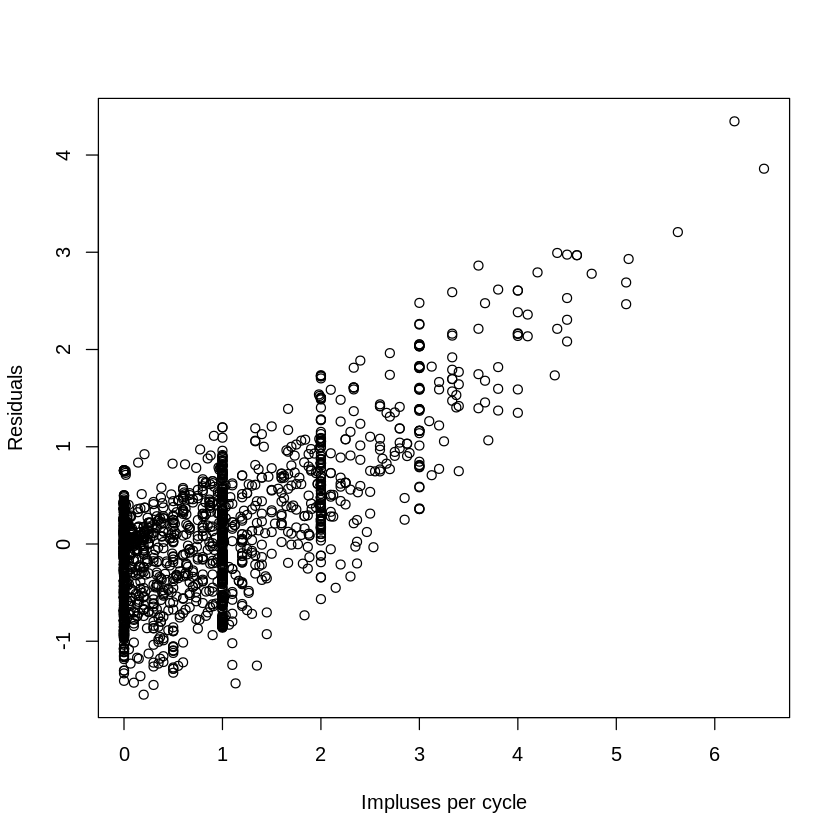

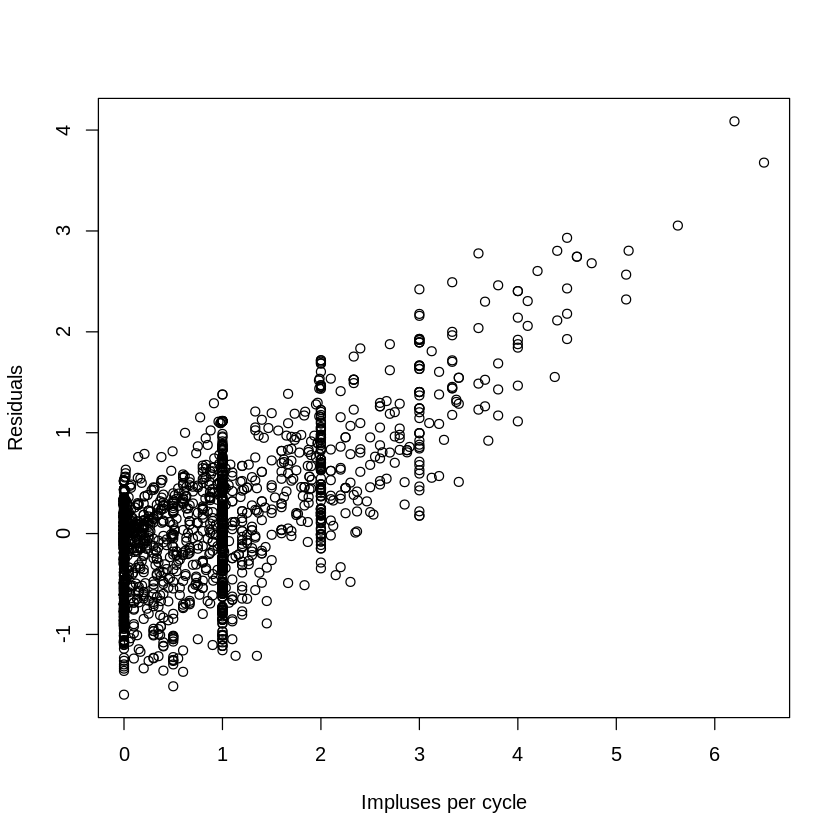

In [10]:
#the plot proves the transformation guessed in the 1.e
#todo: adding afferent classes to see the effects of them on impCycle

firstMain <- geeglm(impCycle ~ frequency + amplitude + FAII + SAI + SAII,
               data = footJoinedDum,
               id=newID,
               corstr = "exchangeable")

firstSecond <- geeglm(impCycle ~ frequency + amplitude+ frequency*amplitude + FAII + SAI + SAII,
               data = footJoinedDum,
               id=newID,
               corstr = "exchangeable")
summary(firstMain)
plot(footJoinedDum$impCycle, resid(firstMain), ylab="Residuals", xlab="Impluses per cycle")
summary(firstSecond)
plot(footJoinedDum$impCycle, resid(firstSecond), ylab="Residuals", xlab="Impluses per cycle")


In [11]:
impLog <- footJoinedDum[, c("impCycle", "frequency", "amplitude", "newID",'FAI','FAII','SAI','SAII')]
impLog$impCycle <- log(impLog$impCycle)
impLog<-impLog[!(impLog$impCycle=="-Inf" | impLog$frequency=="-Inf" | impLog$amplitude=="-Inf"),]


Call:
geeglm(formula = impCycle ~ frequency + amplitude + FAII + SAI + 
    SAII, data = impLog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate  Std.err   Wald Pr(>|W|)    
(Intercept) -0.92957  0.11353  67.04  2.2e-16 ***
frequency   -0.01103  0.00167  43.66  3.9e-11 ***
amplitude    0.84461  0.05465 238.83  < 2e-16 ***
FAII         0.84600  0.14748  32.91  9.7e-09 ***
SAI         -0.16819  0.16261   1.07   0.3010    
SAII        -0.49771  0.15460  10.36   0.0013 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.699  0.0576
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.234  0.0471
Number of clusters:   69  Maximum cluster size: 74 


Call:
geeglm(formula = impCycle ~ frequency + amplitude + frequency * 
    amplitude, data = impLog, id = newID, corstr = "exchangeable")

 Coefficients:
                    Estimate  Std.err   Wald Pr(>|W|)    
(Intercept)         -0.95516  0.10747  78.99  < 2e-16 ***
frequency           -0.01121  0.00203  30.50  3.3e-08 ***
amplitude            0.81780  0.06549 155.92  < 2e-16 ***
frequency:amplitude  0.00156  0.00242   0.42     0.52    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.906  0.0956
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha     0.43  0.0577
Number of clusters:   69  Maximum cluster size: 74 

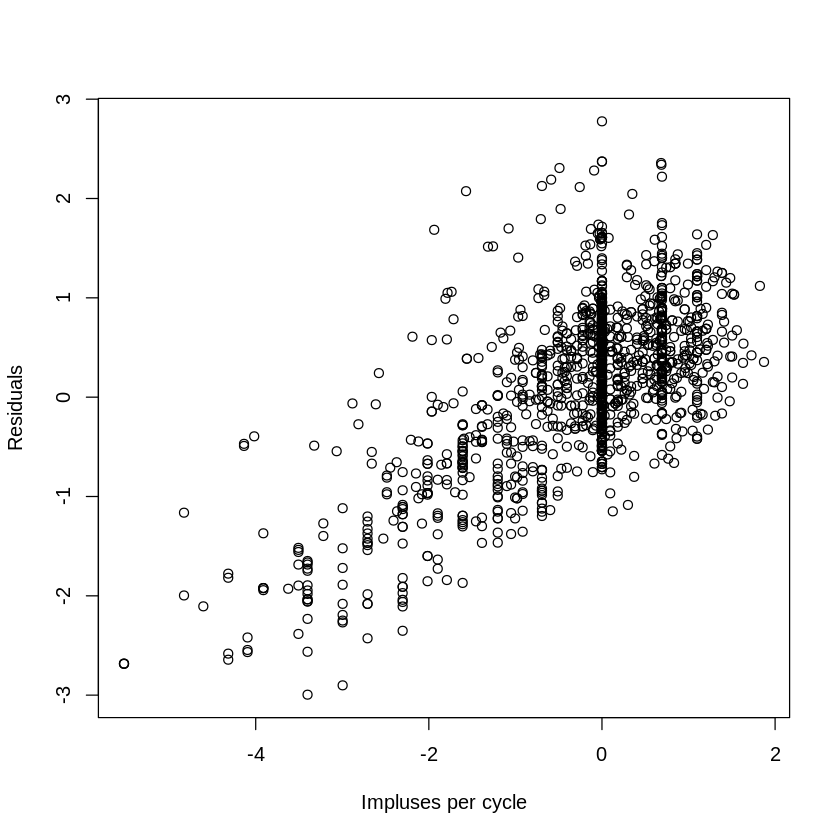

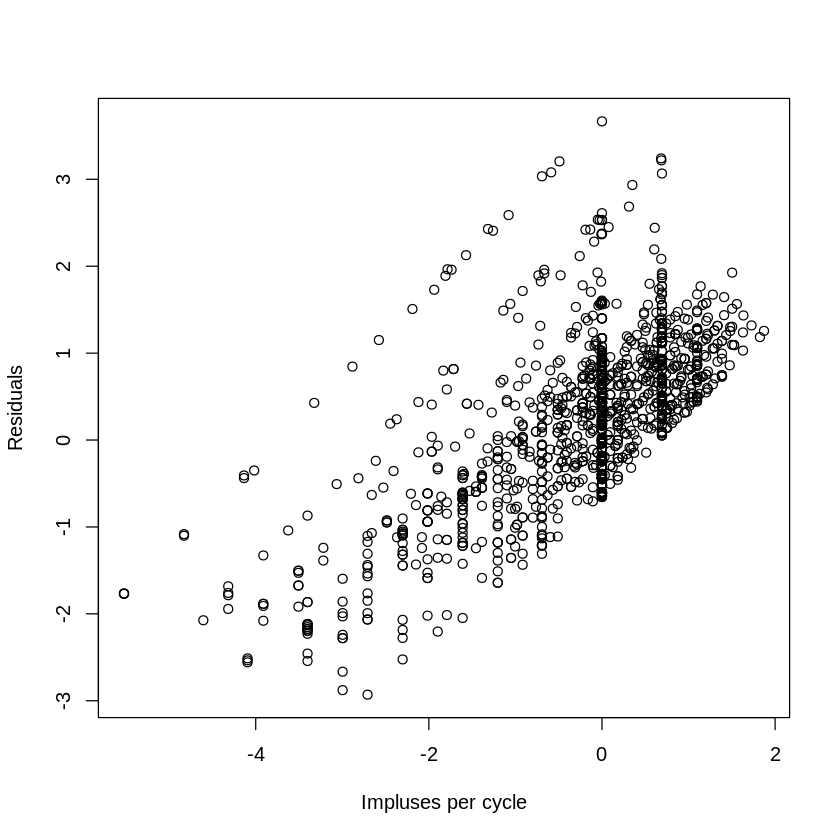

In [12]:
#the plot proves the transformation guessed in the 1.e
#todo: adding afferent classes to see the effects of them on impCycle

secondMain <- geeglm(impCycle ~ frequency + amplitude + FAII + SAI + SAII,
               data = impLog,
               id=newID,
               corstr = "exchangeable")

secondSecond <- geeglm(impCycle ~ frequency+amplitude+frequency*amplitude,
               data = impLog,
               id=newID,
               corstr = "exchangeable")
summary(secondMain)
plot(impLog$impCycle, resid(secondMain), ylab="Residuals", xlab="Impluses per cycle")

summary(secondSecond)
plot(impLog$impCycle, resid(secondSecond), ylab="Residuals", xlab="Impluses per cycle")


In [13]:
allLog <- footJoinedDum[, c("impCycle", "frequency", "amplitude", "newID",'FAI','FAII','SAI','SAII')]
allLog$impCycle <- log(allLog$impCycle)
allLog$frequency <- log(allLog$frequency)
allLog$amplitude <- log(allLog$amplitude)
allLog<-allLog[!(allLog$impCycle=="-Inf" | allLog$frequency=="-Inf" | allLog$amplitude=="-Inf"),]


Call:
geeglm(formula = impCycle ~ frequency + amplitude + FAII + SAI + 
    SAII, data = allLog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate Std.err   Wald Pr(>|W|)    
(Intercept)   0.8521  0.1679  25.75  3.9e-07 ***
frequency    -0.3643  0.0467  60.79  6.3e-15 ***
amplitude     0.6292  0.0517 147.98  < 2e-16 ***
FAII          0.9742  0.1670  34.01  5.5e-09 ***
SAI          -0.1965  0.1558   1.59     0.21    
SAII         -0.5991  0.1414  17.94  2.3e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.552  0.0561
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.304  0.0557
Number of clusters:   69  Maximum cluster size: 74 


Call:
geeglm(formula = impCycle ~ frequency + amplitude + frequency * 
    amplitude, data = allLog, id = newID, corstr = "exchangeable")

 Coefficients:
                    Estimate Std.err  Wald Pr(>|W|)    
(Intercept)           0.7450  0.1045 50.82  1.0e-12 ***
frequency            -0.3356  0.0365 84.29  < 2e-16 ***
amplitude             0.5182  0.1058 23.97  9.8e-07 ***
frequency:amplitude   0.0328  0.0408  0.65     0.42    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.843   0.111
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.575  0.0533
Number of clusters:   69  Maximum cluster size: 74 

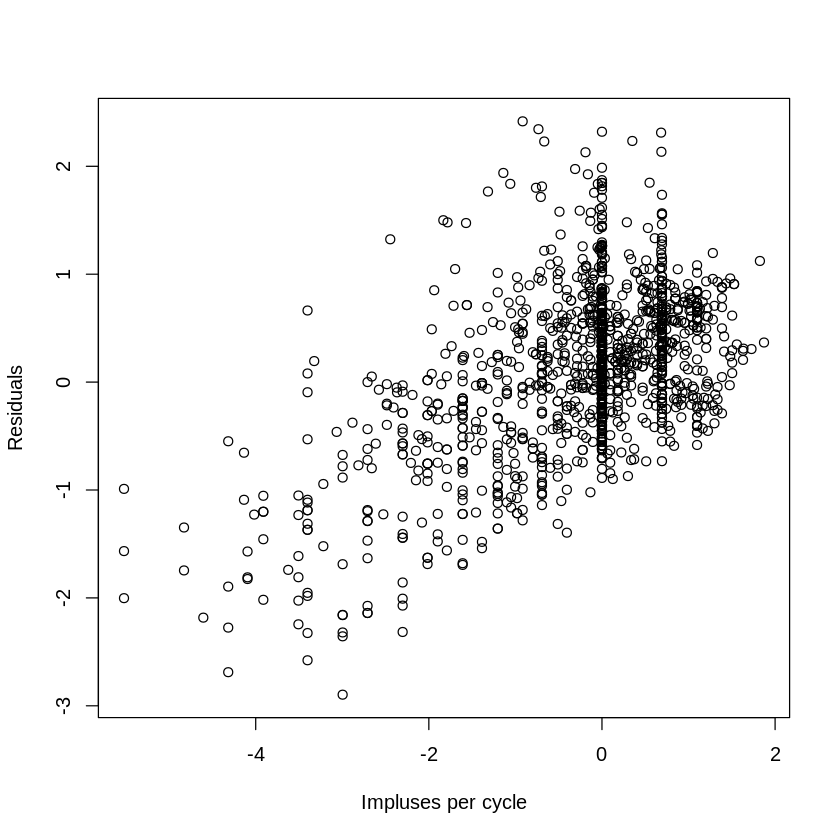

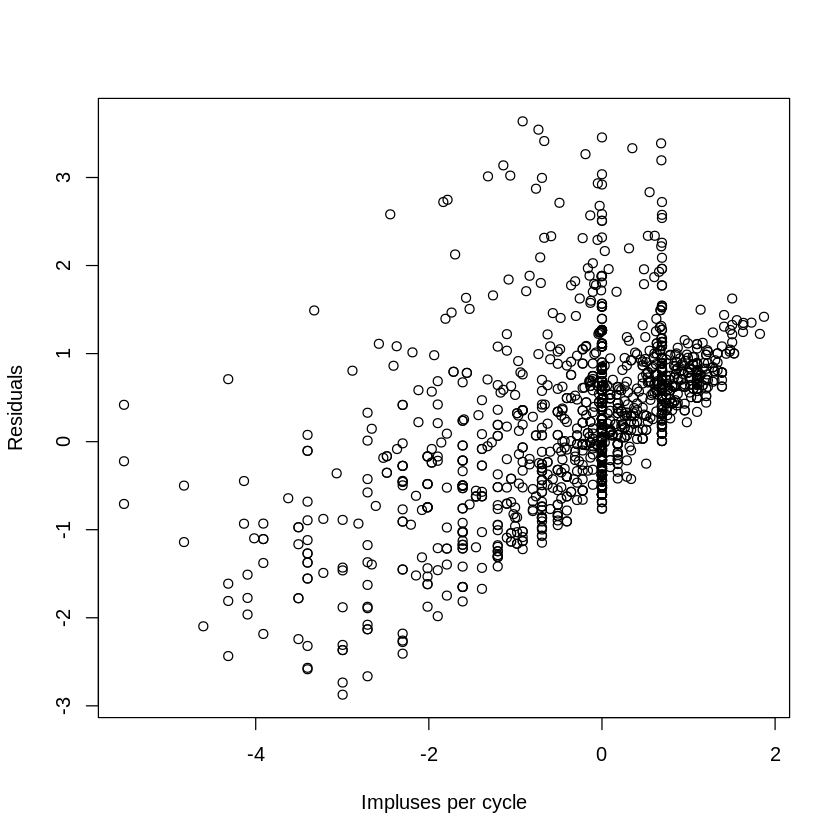

In [14]:
thirdMain <- geeglm(impCycle ~ frequency + amplitude + FAII + SAI + SAII,
               data = allLog,
               id=newID,
               corstr = "exchangeable")

thirdSecond <- geeglm(impCycle ~ frequency+amplitude+frequency*amplitude,
               data = allLog,
               id=newID,
               corstr = "exchangeable")
summary(thirdMain)
plot(allLog$impCycle, resid(thirdMain), ylab="Residuals", xlab="Impluses per cycle")

summary(thirdSecond)
plot(allLog$impCycle, resid(thirdSecond), ylab="Residuals", xlab="Impluses per cycle")

#Q3

In [15]:
freqUniq <- footJoined %>%
  group_by(newID, frequency) %>%
  summarize(newID=max(newID, na.rm = TRUE), afferentClass=unique(afferentClass), frequency=max(frequency, na.rm = TRUE), firingThreshold = max(firingThreshold, na.rm = TRUE))

  freqUniqDum = cbind(freqUniq,model.matrix(~freqUniq$afferentClass-1, data=freqUniq))

`summarise()` has grouped output by 'newID'. You can override using the
`.groups` argument.


In [16]:
colnames(freqUniqDum) <- c('newID','frequency','afferentClass','firingThreshold','FAI','FAII','SAI','SAII')


Call:
geeglm(formula = firingThreshold ~ frequency + FAII + SAI + SAII, 
    data = freqUniqDum, id = newID, corstr = "exchangeable")

 Coefficients:
             Estimate   Std.err  Wald Pr(>|W|)    
(Intercept)  0.525288  0.088193 35.48  2.6e-09 ***
frequency   -0.001172  0.000348 11.33  0.00076 ***
FAII        -0.310030  0.085897 13.03  0.00031 ***
SAI         -0.035770  0.143267  0.06  0.80284    
SAII         0.210779  0.154594  1.86  0.17275    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.167  0.0298
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.531  0.0792
Number of clusters:   52  Maximum cluster size: 10 

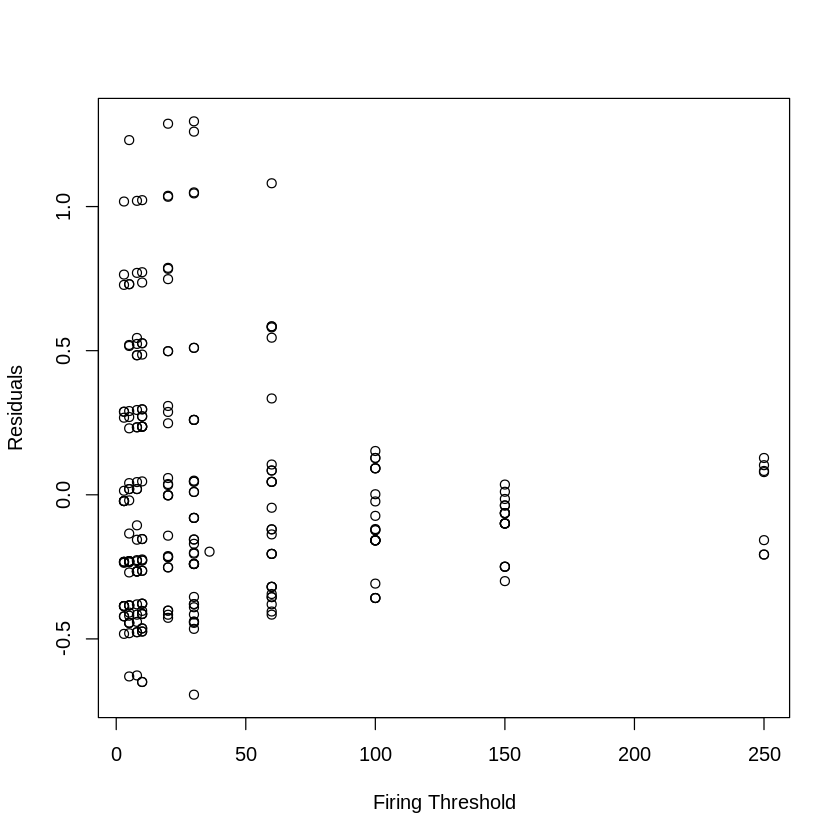

In [17]:
#the plot proves the transformation guessed in the 1.e
#todo: running the model by log
#todo: adding afferent classes to see the effects of them on impCycle

f1Main <- geeglm(firingThreshold ~ frequency + FAII + SAI + SAII,
               data = freqUniqDum,
               id=newID,
               corstr = "exchangeable")

summary(f1Main)
plot(freqUniqDum$frequency, resid(f1Main), ylab="Residuals", xlab="Firing Threshold")

In [18]:
yLog <- freqUniqDum
yLog$firingThreshold <- log(yLog$firingThreshold)
#yLog<-yLog[!(yLog$impCycle=="-Inf"),]


Call:
geeglm(formula = firingThreshold ~ frequency + FAII + SAI + SAII, 
    data = yLog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate  Std.err  Wald Pr(>|W|)    
(Intercept) -1.00258  0.22420 20.00  7.8e-06 ***
frequency   -0.00638  0.00177 13.00  0.00031 ***
FAII        -1.39914  0.35370 15.65  7.6e-05 ***
SAI         -0.20360  0.34594  0.35  0.55616    
SAII         0.35113  0.37194  0.89  0.34514    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)     1.24   0.144
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.432  0.0761
Number of clusters:   52  Maximum cluster size: 10 

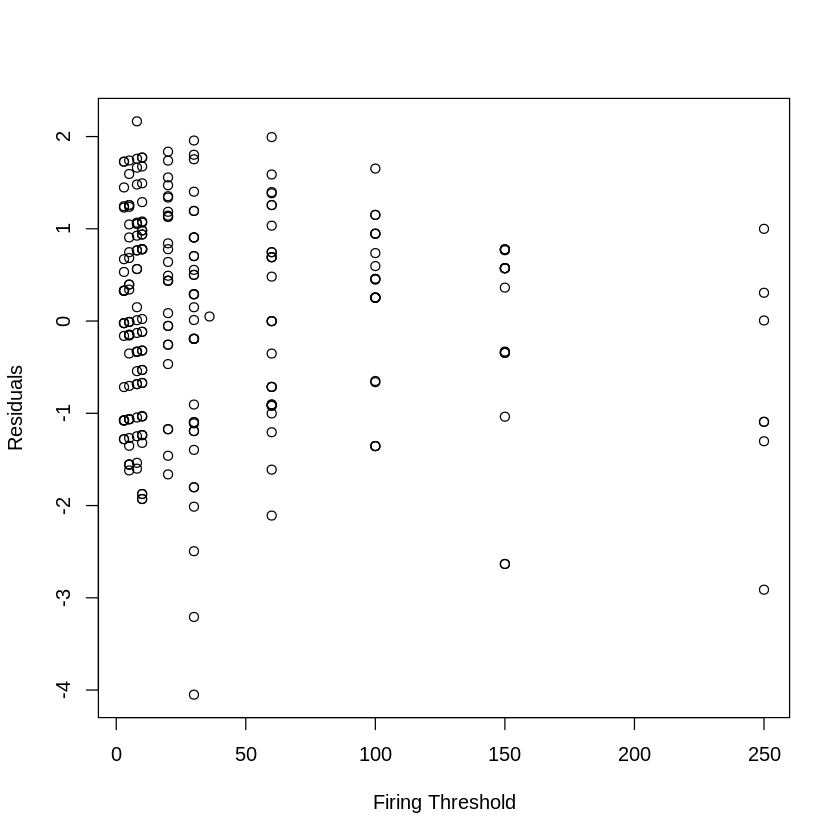

In [19]:
f2Main <- geeglm(firingThreshold ~ frequency + FAII + SAI + SAII,
               data = yLog,
               id=newID,
               corstr = "exchangeable")

summary(f2Main)
plot(yLog$frequency, resid(f2Main), ylab="Residuals", xlab="Firing Threshold")

In [20]:
allLog <- freqUniqDum
allLog$firingThreshold <- log(allLog$firingThreshold)
allLog$frequency <- log(allLog$frequency)
#yLog<-yLog[!(yLog$impCycle=="-Inf"),]


Call:
geeglm(formula = firingThreshold ~ frequency + FAII + SAI + SAII, 
    data = allLog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate Std.err  Wald Pr(>|W|)    
(Intercept)  -0.6156  0.3468  3.15    0.076 .  
frequency    -0.2138  0.0843  6.44    0.011 *  
FAII         -1.4815  0.3730 15.78  7.1e-05 ***
SAI          -0.1888  0.3492  0.29    0.589    
SAII          0.3580  0.3782  0.90    0.344    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)     1.31   0.161
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.438  0.0773
Number of clusters:   52  Maximum cluster size: 10 

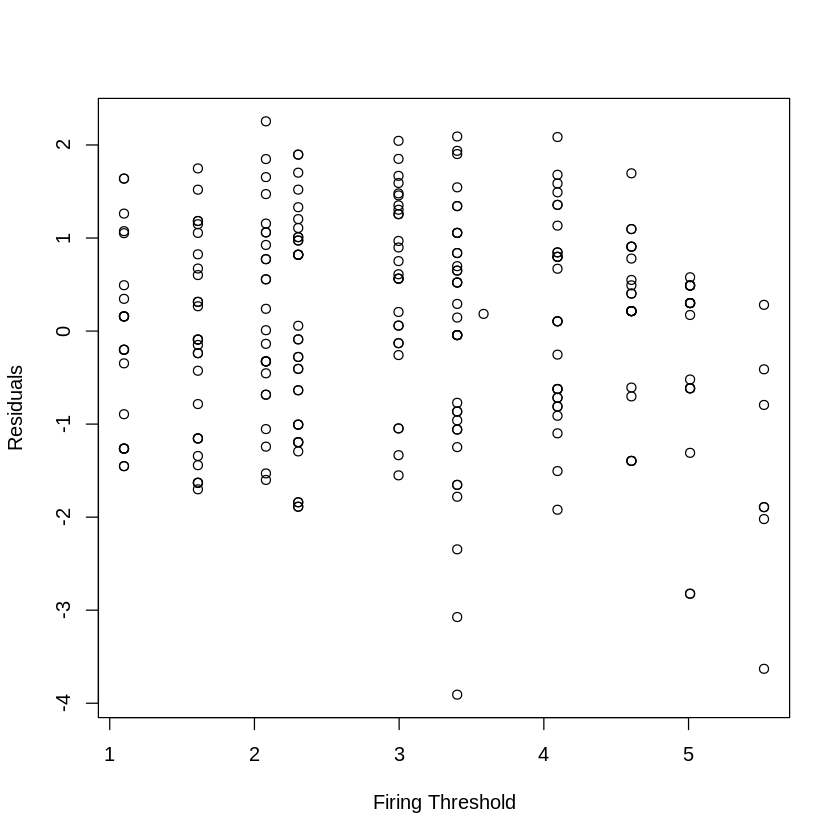

In [21]:
f3Main <- geeglm(firingThreshold ~ frequency + FAII + SAI + SAII,
               data = allLog,
               id=newID,
               corstr = "exchangeable")

summary(f3Main)
plot(allLog$frequency, resid(f3Main), ylab="Residuals", xlab="Firing Threshold")

#Q4

In [22]:
entrUniq <- footJoined %>%
  group_by(newID, frequency) %>%
  summarize(newID=min(newID, na.rm = TRUE), afferentClass=unique(afferentClass), frequency=min(frequency, na.rm = TRUE), entrainThreshold = min(entrainThreshold, na.rm = TRUE))
entrUniq<-entrUniq[!(entrUniq$entrainThreshold=="Inf"),]

entrUniqDum = cbind(entrUniq,model.matrix(~entrUniq$afferentClass-1, data=entrUniq))

Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in min(entrainThreshold, na.rm = TRUE):

In [23]:
colnames(entrUniqDum) <- c('newID','frequency','afferentClass','entrainThreshold','FAI','FAII','SAI','SAII')


Call:
geeglm(formula = entrainThreshold ~ frequency + FAII + SAI + 
    SAII, data = entrUniqDum, id = newID, corstr = "exchangeable")

 Coefficients:
             Estimate   Std.err  Wald Pr(>|W|)    
(Intercept)  0.921785  0.122609 56.52  5.6e-14 ***
frequency   -0.001423  0.000717  3.93    0.047 *  
FAII        -0.549736  0.118264 21.61  3.3e-06 ***
SAI          0.030108  0.158078  0.04    0.849    
SAII         0.119632  0.165461  0.52    0.470    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.212  0.0332
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.539  0.0876
Number of clusters:   49  Maximum cluster size: 9 

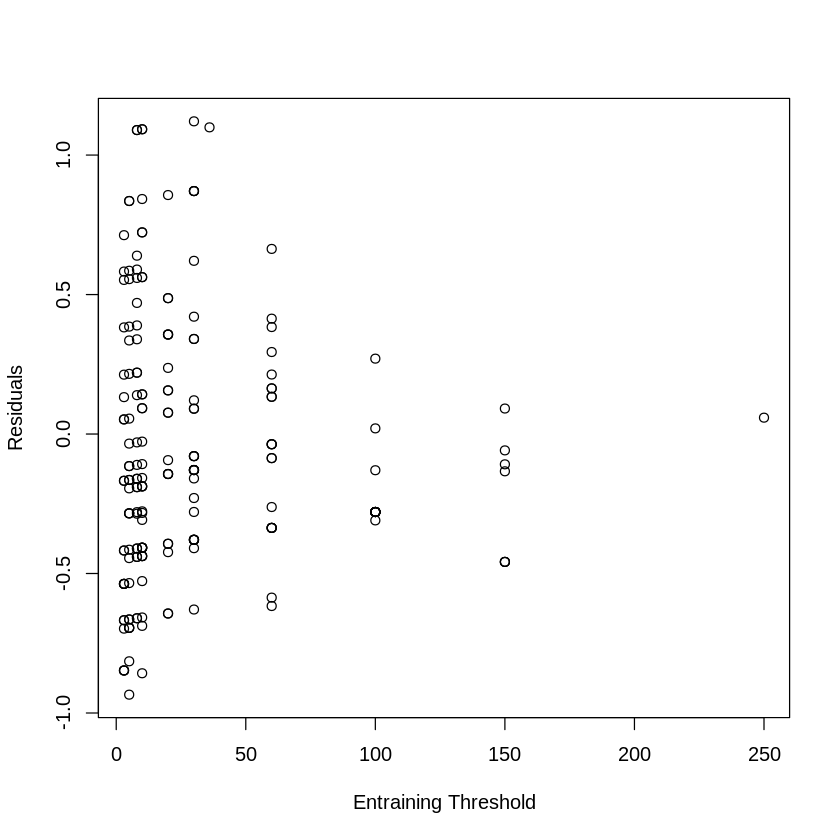

In [24]:
#the plot proves the transformation guessed in the 1.e
#todo: running the model by log
#todo: adding afferent classes to see the effects of them on impCycle

e1Main <- geeglm(entrainThreshold ~ frequency + FAII + SAI + SAII,
               data = entrUniqDum,
               id=newID,
               corstr = "exchangeable")

summary(e1Main)
plot(entrUniq$frequency, resid(e1Main), ylab="Residuals", xlab="Entraining Threshold")

In [25]:
eLog <- entrUniqDum
eLog$entrainThreshold <- log(eLog$entrainThreshold)
#yLog<-yLog[!(yLog$impCycle=="-Inf"),]


Call:
geeglm(formula = entrainThreshold ~ frequency + FAII + SAI + 
    SAII, data = eLog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate  Std.err  Wald Pr(>|W|)    
(Intercept) -0.27575  0.16579  2.77    0.096 .  
frequency   -0.00333  0.00212  2.46    0.117    
FAII        -1.12751  0.23987 22.09  2.6e-06 ***
SAI          0.00867  0.19611  0.00    0.965    
SAII         0.19506  0.20668  0.89    0.345    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.557  0.0715
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.301  0.0998
Number of clusters:   49  Maximum cluster size: 9 

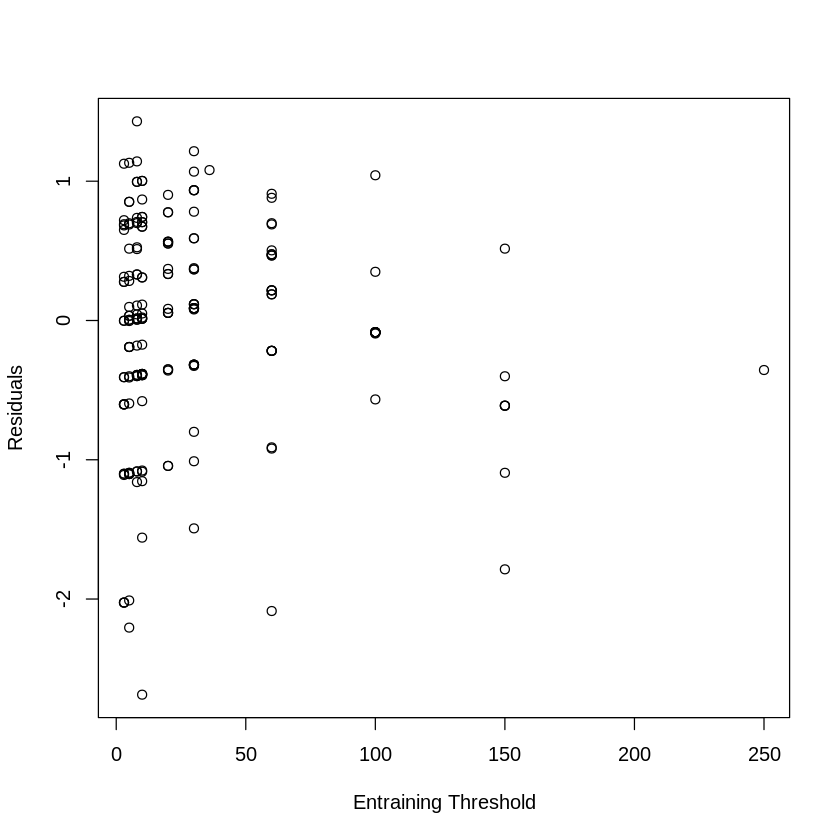

In [26]:
e2Main <- geeglm(entrainThreshold ~ frequency + FAII + SAI + SAII,
               data = eLog,
               id=newID,
               corstr = "exchangeable")

summary(e2Main)
plot(eLog$frequency, resid(e2Main), ylab="Residuals", xlab="Entraining Threshold")

In [27]:
allELog <- entrUniqDum
allELog$entrainThreshold <- log(allELog$entrainThreshold)
allELog$frequency <- log(allELog$frequency)
#yLog<-yLog[!(yLog$impCycle=="-Inf"),]


Call:
geeglm(formula = entrainThreshold ~ frequency + FAII + SAI + 
    SAII, data = allELog, id = newID, corstr = "exchangeable")

 Coefficients:
            Estimate Std.err  Wald Pr(>|W|)    
(Intercept)  -0.3550  0.3027  1.37     0.24    
frequency    -0.0101  0.0836  0.01     0.90    
FAII         -1.1793  0.2512 22.04  2.7e-06 ***
SAI           0.0601  0.1999  0.09     0.76    
SAII          0.2650  0.2213  1.43     0.23    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = exchangeable 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.584  0.0806
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha     0.32   0.103
Number of clusters:   49  Maximum cluster size: 9 

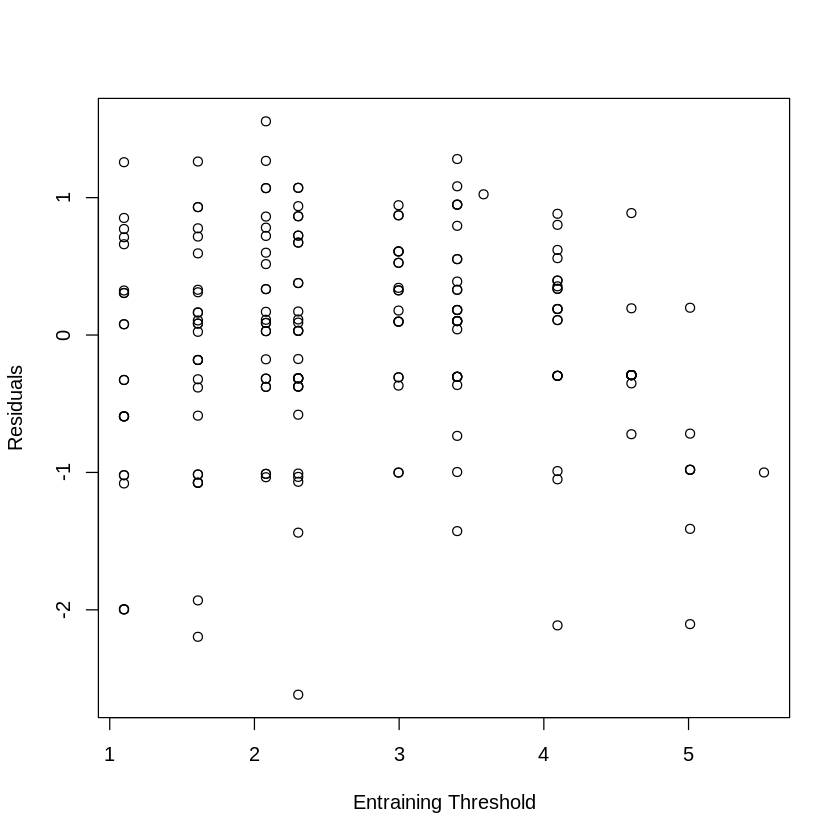

In [28]:
e3Main <- geeglm(entrainThreshold ~ frequency + FAII + SAI + SAII,
               data = allELog,
               id=newID,
               corstr = "exchangeable")

summary(e3Main)
plot(allELog$frequency, resid(e3Main), ylab="Residuals", xlab="Entraining Threshold")

#Q5